In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skfuzzy import cmeans
import glob

In [29]:
class WBCDataLoader:
    def __init__(self, dataset_path, img_size=(200, 200)):
        self.img_dir = os.path.join(dataset_path, 'train', 'original')
        self.mask_dir = os.path.join(dataset_path, 'train', 'mask')
        self.img_size = img_size

        image_paths = glob.glob(os.path.join(self.img_dir, '*.jpg'))
        self.samples = []
        for img_path in image_paths:
            base = os.path.splitext(os.path.basename(img_path))[0]
            mask_path = os.path.join(self.mask_dir, f"{base}.png")
            if os.path.exists(mask_path):
                self.samples.append((img_path, mask_path))

        print(f"Found {len(self.samples)} image-mask pairs")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)
        mask = (mask > 0).astype(np.uint8)

        return img, mask

# Initialize dataloader using the provided dataset path
dataset_root = r"C:\sem-6\DLMI_assignments\data"
dataloader = WBCDataLoader(dataset_root)

Found 106 image-mask pairs


In [30]:
def segment_kmeans(img, n_clusters=3):
    pixels = img.reshape((-1, 3)).astype(np.float32)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels)
    return labels.reshape(img.shape[:2])

def segment_fcm(img, n_clusters=3):
    pixels = img.reshape((-1, 3)).T.astype(np.float64)
    cntr, u, u0, d, jm, p, fpc = cmeans(pixels, n_clusters, 2, error=0.005, maxiter=1000)
    labels = np.argmax(u, axis=0)
    return labels.reshape(img.shape[:2])

In [31]:
def extract_boundary(segmentation):
    """Extract boundaries from a label or binary mask using morphological gradient"""
    kernel = np.ones((3, 3), np.uint8)
    boundary = cv2.morphologyEx(segmentation.astype(np.uint8), cv2.MORPH_GRADIENT, kernel)
    return (boundary > 0).astype(np.uint8)

def calculate_boundary_metrics(boundary_gt, boundary_pred):
    """Calculate accuracy, precision, recall, F1 for boundary comparison"""
    TP = np.logical_and(boundary_gt, boundary_pred).sum()
    TN = np.logical_and(~boundary_gt.astype(bool), ~boundary_pred.astype(bool)).sum()
    FP = np.logical_and(~boundary_gt.astype(bool), boundary_pred).sum()
    FN = np.logical_and(boundary_gt, ~boundary_pred.astype(bool)).sum()

    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

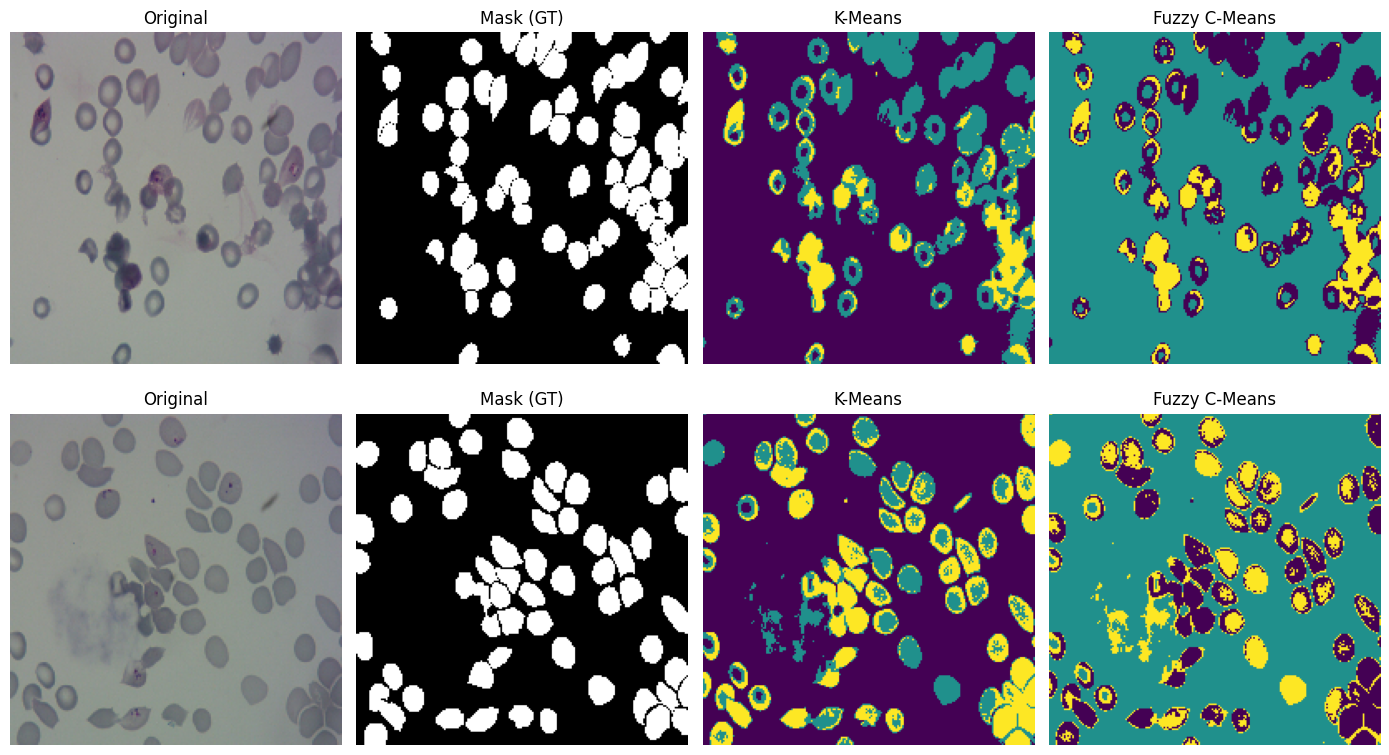

In [32]:
# Test on 2 samples with masks
fig, axes = plt.subplots(2, 4, figsize=(14, 8))

for i in range(2):
    img, mask = dataloader[i]

    kmeans_seg = segment_kmeans(img, n_clusters=3)
    fcm_seg = segment_fcm(img, n_clusters=3)

    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title('Mask (GT)')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(kmeans_seg, cmap='viridis')
    axes[i, 2].set_title('K-Means')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(fcm_seg, cmap='viridis')
    axes[i, 3].set_title('Fuzzy C-Means')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()


In [33]:
kmeans_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
fcm_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

for i in range(len(dataloader)):
    img, mask = dataloader[i]

    kmeans_seg = segment_kmeans(img, n_clusters=3)
    fcm_seg = segment_fcm(img, n_clusters=3)

    gt_boundary = extract_boundary(mask)
    kmeans_boundary = extract_boundary(kmeans_seg)
    fcm_boundary = extract_boundary(fcm_seg)

    km = calculate_boundary_metrics(gt_boundary, kmeans_boundary)
    fm = calculate_boundary_metrics(gt_boundary, fcm_boundary)

    for key in kmeans_scores:
        kmeans_scores[key].append(km[key])
        fcm_scores[key].append(fm[key])

# Pretty print averages
print("K-Means Boundary Metrics (dataset average)")
for key, values in kmeans_scores.items():
    print(f"  {key}: {np.mean(values):.4f}")

print("\nFuzzy C-Means Boundary Metrics (dataset average)")
for key, values in fcm_scores.items():
    print(f"  {key}: {np.mean(values):.4f}")

K-Means Boundary Metrics (dataset average)
  accuracy: 0.8405
  precision: 0.4868
  recall: 0.8495
  f1_score: 0.6093

Fuzzy C-Means Boundary Metrics (dataset average)
  accuracy: 0.8120
  precision: 0.4414
  recall: 0.8484
  f1_score: 0.5694
